In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal as ss
import pickle
import scipy.linalg as sl

- Signal and dictionary upload
- Predefined data

In [2]:
name = "mati"
signal_type = "ruch"
merged= np.load(f"{name}_{signal_type}_dane.npy")
with open(f"{name}_{signal_type}_EEG.pkl", "rb") as f:
    EEG_mati = pickle.load(f)

Fs = int(EEG_mati["sampling"])
channels_names = EEG_mati['channels_names']
locs_uni = [2, 4,
          6, 7, 8, 9, 10,
          11, 12, 13, 14, 15,
          16, 17, 18, 19,20,
          22,24] # system 10-20; pozycje do wyplotowania na subplotach 5x5

locs_standard = [i for i in range(1,20)]
_, trials_count, channels_count, samples_count = merged.shape

- Shape check to examin good upload of data

In [3]:
EEG_mati['lewa'].shape

(30, 19, 2048)

SPECTROGRAM AND VISUALIZATION FUNCTIONS

In [4]:
def spectrogram(signal, hand = None, fs = Fs, nlap = True):


  # hand -> [int] 0- left, 1 - right
  
  NFFT  = int(fs)
  h = ss.windows.hamming(NFFT)

  if nlap:
    noverlap_set = NFFT - 1
  else:
    noverlap_set = NFFT - 10

  if hand != None:
    signal = signal[hand]
    print("Hand is not None") #for debugging reasons

  f, t, Sxx = ss.spectrogram(signal, fs, nperseg= NFFT, noverlap = noverlap_set, scaling = 'spectrum', window = h, axis = -1)
  Sxx_mean = np.mean(Sxx, axis = 0)

  return Sxx, t, f, Sxx_mean

In [7]:
def EEG_topology(mapa, t, f, title, f_limit=50, l=locs_uni, fs=Fs, ch_names=channels_names, ax_title = channels_names, global_scale=False, vmin = None, vmax = None):
    """
    Wizualizacja mapy czasowo-częstotliwościowej EEG dla wielu kanałów.
    
    Parametry:
    - mapa: lista lub tablica NumPy z danymi EEG (kanały na częstotliwości na czas)
    - t: oś czasu
    - f: oś częstotliwości
    - title: tytuł wykresu
    - f_limit: maksymalna częstotliwość do wyświetlenia (domyślnie 50 Hz)
    - l: układ kanałów EEG (lokalizacje w siatce subplotów)
    - fs: częstotliwość próbkowania
    - ch_names: nazwy kanałów EEG
    - global_scale: jeśli True, używa wspólnej skali kolorów dla wszystkich mapek
    """
    
    NFFT = int(fs)
    plt.figure(figsize=(10, 10))  
    plt.suptitle(title, fontsize=20, fontfamily='serif', fontweight='bold')

    # Ustalanie zakresu kolorów dla globalnej skali
    if global_scale:
        all_data = np.array([mapa[ch][:f_limit, :] for ch in range(len(ch_names))])
        if vmin == None and  vmax == None:
            vmin, vmax = np.min(all_data), np.max(all_data)  # Wspólna skala kolorów

    axes = []
    for ch in range(len(ch_names)):
        ax = plt.subplot(5, 5, l[ch])
        ax.set_title(ax_title[ch], fontsize=10)
        axes.append(ax)

        # Rysowanie mapy EEG z opcjonalną globalną skalą kolorów
        im = ax.imshow(
            mapa[ch][:f_limit, :], 
            aspect='auto', 
            origin='lower',
            extent=(t[0] - (NFFT / 2) / fs - 2, t[-1] - (NFFT / 2) / fs - 2, f[0], f[f_limit]),
            interpolation='nearest',
            cmap='coolwarm',  # Możesz zmienić np. na 'plasma', 'viridis'
            vmin=vmin, vmax=vmax  # Jeśli global_scale=True, ustawia stałą skalę kolorów
        )

        # Linia odniesienia (teraz jasnoszara, żeby była widoczna na każdej mapie)
        ax.axvline(x=0, color='w', linestyle='--', alpha=0.5)

    # Dodanie wspólnej skali kolorów tylko jeśli global_scale=True
    if global_scale:
        cbar_ax = plt.gcf().add_axes([0.92, 0.3, 0.02, 0.4])  # Wspólna oś dla colorbar
        plt.colorbar(im, cax=cbar_ax)
    
    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Dopasowanie, żeby nie nachodziło na colorbar
    plt.show()


- Spectrogram calculation + visualization on 10-20 topology
- Frequencies interesting in this application should be in miu band, so that's why the freq axis can be limited to have a closer look on the activated rythms

Hand is not None


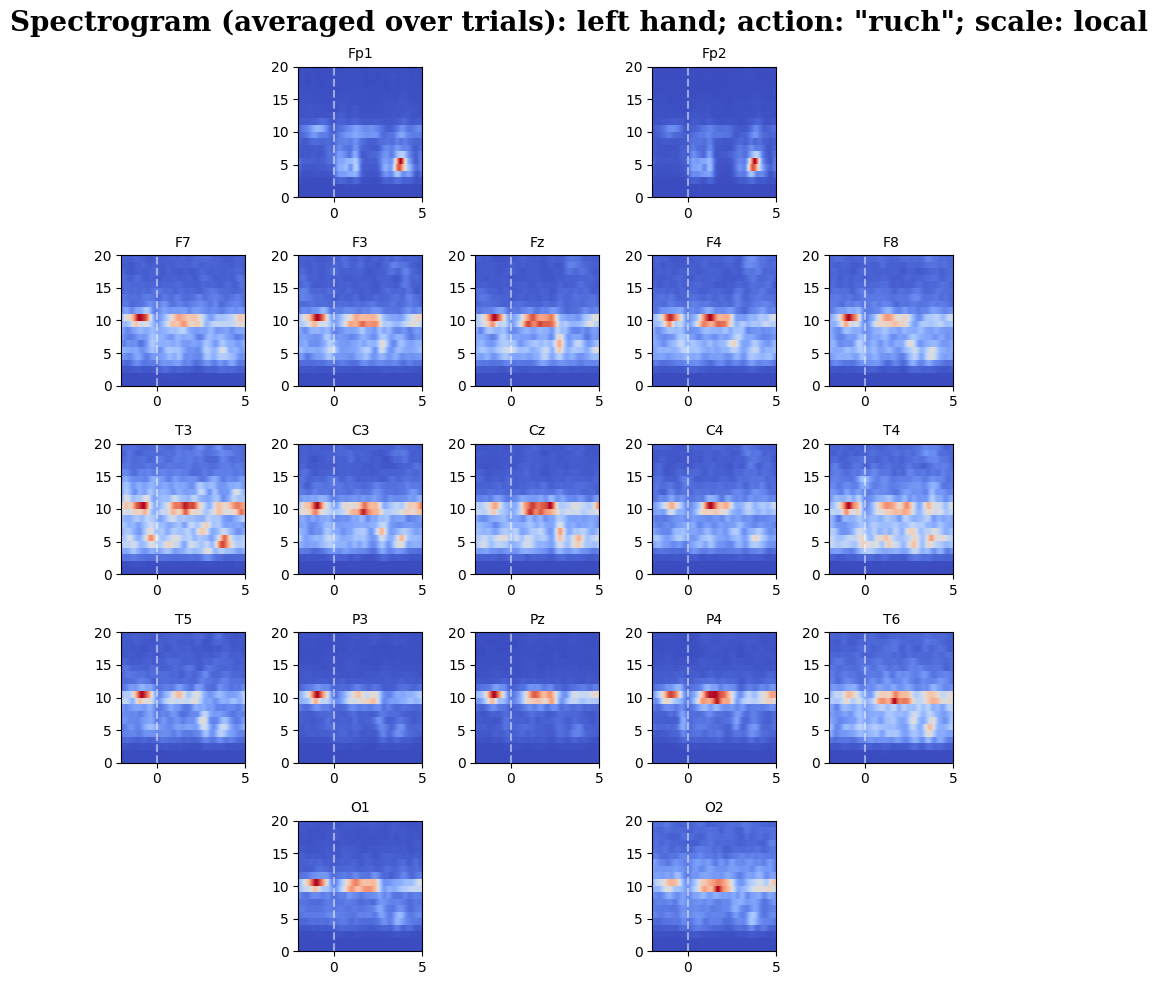

In [8]:
side = ['left', 0]
scale = 'local'
freq_limit = 20

Sxx_left, t_left, f_left, Sxx_mean_left= spectrogram(merged, side[1])
EEG_topology(Sxx_mean_left, t_left, f_left, title = f'Spectrogram (averaged over trials): {side[0]} hand; action: "{signal_type}"; scale: {str(scale)}', f_limit = freq_limit, global_scale=False)

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_4652/2889181743.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Dopasowanie, żeby nie nachodziło na colorbar


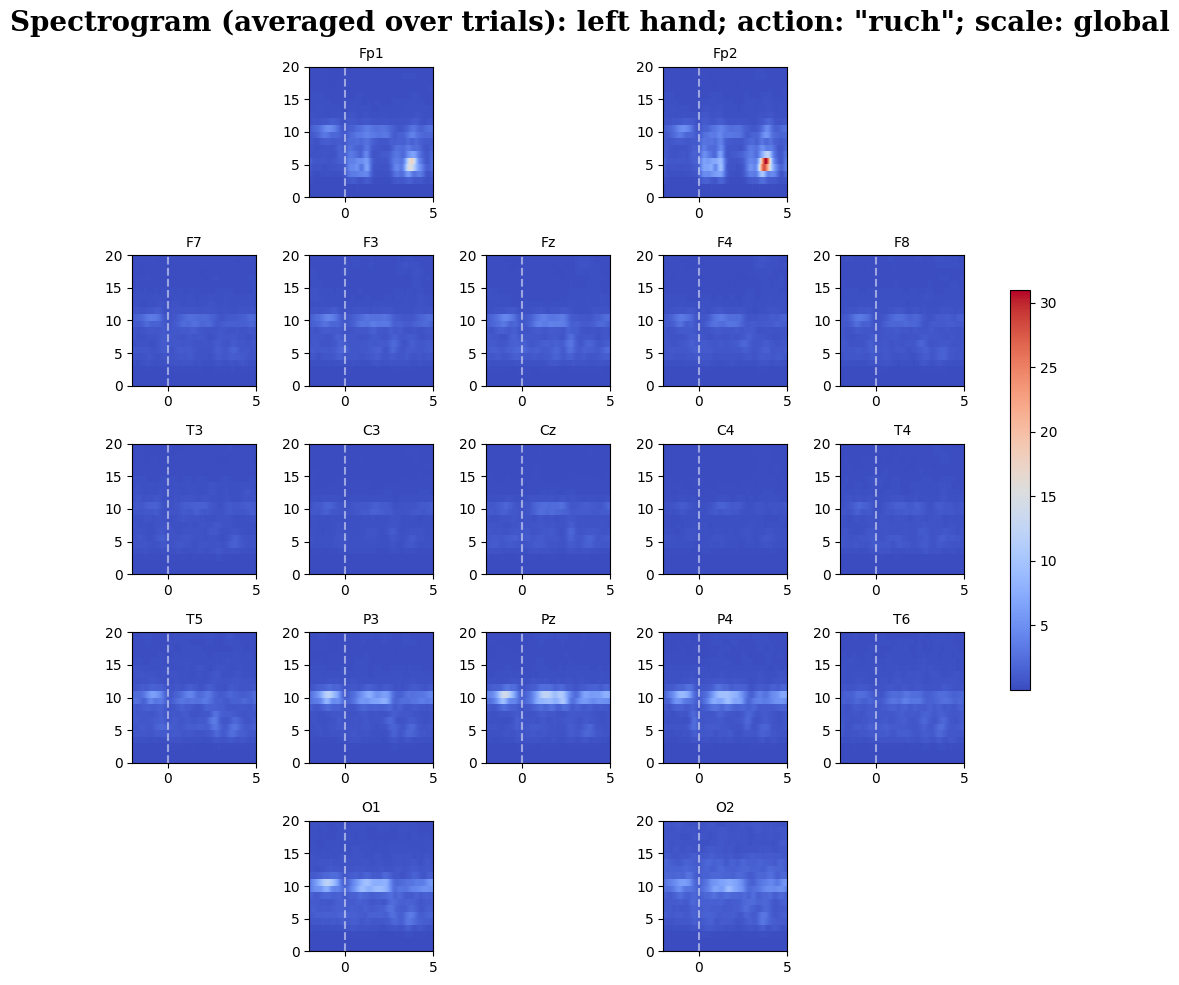

In [9]:
side = ['left', 0]
scale = 'global'
freq_limit = 20

#Sxx_left, t_left, f_left, Sxx_mean_left= spectrogram(merged, side[1]) #we don't need to calculate it one more time, because the calc from previous 
EEG_topology(Sxx_mean_left, t_left, f_left, title = f'Spectrogram (averaged over trials): {side[0]} hand; action: "{signal_type}"; scale: {str(scale)}', f_limit = freq_limit, global_scale=True)

Hand is not None


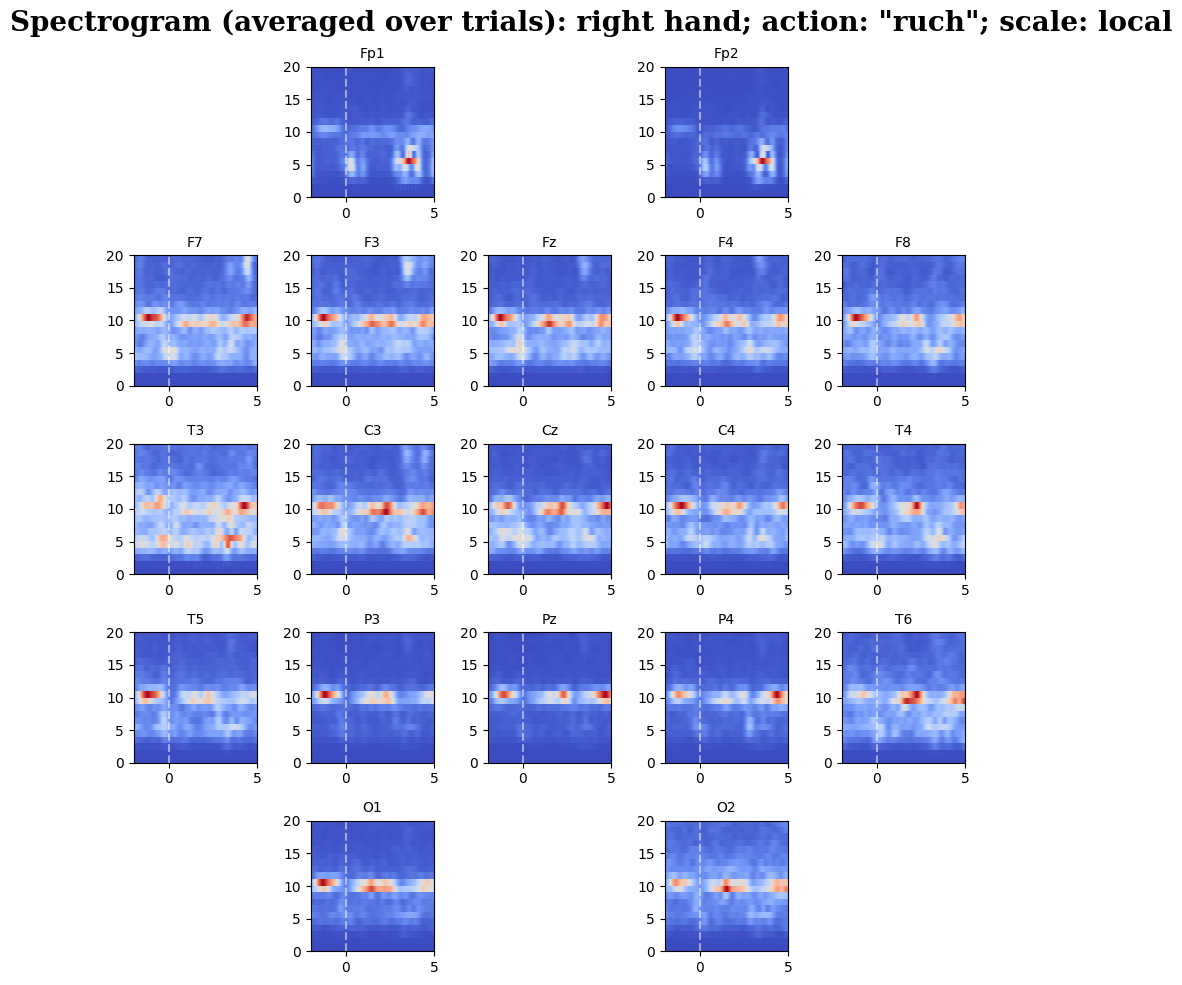

In [11]:
side = ['right', 1]
scale = 'local'
freq_limit = 20

Sxx_right, t_right, f_right, Sxx_mean_right= spectrogram(merged, side[1])
EEG_topology(Sxx_mean_right, t_right, f_right, title = f'Spectrogram (averaged over trials): {side[0]} hand; action: "{signal_type}"; scale: {str(scale)}', f_limit = freq_limit, global_scale=False)

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_4652/2889181743.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Dopasowanie, żeby nie nachodziło na colorbar


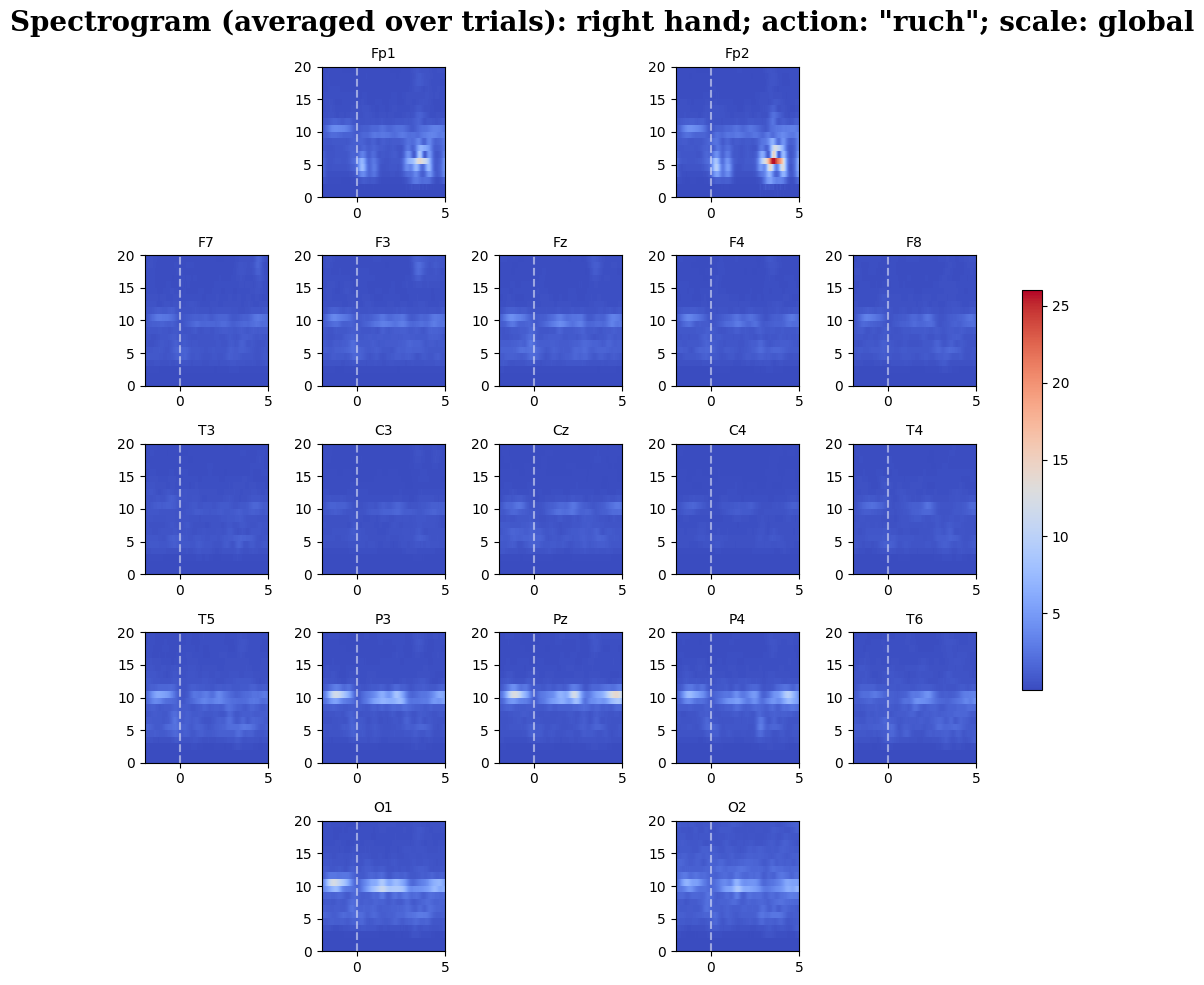

In [12]:
side = ['right', 1]
scale = 'global'
freq_limit = 20

#Sxx_right, t_right, f_right, Sxx_mean_right= spectrogram(merged, side[1])
EEG_topology(Sxx_mean_right, t_right, f_right, title = f'Spectrogram (averaged over trials): {side[0]} hand; action: "{signal_type}"; scale: {str(scale)}', f_limit = freq_limit, global_scale=True)

The interesting part is relative power to baseline. 
Used 2 paradigms: classical ERDS & statistical

b - baseline
f - chosen freq
t - chosen time

#1: S = (P(t,f) - mean(P(b,f)))/ mean(P(b,f)))
#2: S = (miu(t,f) - miu(b,f))/std(b)

In [13]:
def erds(Sxx, fs=Fs, baseline_duration=2):

    start = 0
    stop = int(baseline_duration * fs) 
    
    # Przygotowanie tablicy na wynik (relatywna moc)
    S = np.zeros(Sxx.shape[1:3] + (Sxx.shape[3],)) 
    _, ch_range, f_range, t_range = Sxx.shape

    for ch in range(ch_range):
        for f in range(f_range):
            baseline_data = Sxx[:, ch, f, start:stop]
            baseline_mean = np.mean(np.ndarray.flatten(baseline_data))

            for t in range(t_range):
                current_data = Sxx[:, ch, f, t]
                current_power = np.mean(current_data ** 2)  
                S[ch, f, t] = (current_power - baseline_mean) / baseline_mean
    
    return S

In [14]:
def relative_power(Sxx, fs = Fs):

    # choose baseline
    start = 0
    stop = int(2 * fs)

    S = np.zeros(Sxx.shape[1:3] + (Sxx.shape[3],))  
    _, ch_range, f_range, t_range = Sxx.shape


    for ch in range(ch_range):
        for f in range(f_range):
            baseline_data = Sxx[:, ch, f, start:stop]
            baseline_mean = np.mean(np.ndarray.flatten(baseline_data))
            baseline_std = np.std(np.ndarray.flatten(baseline_data))

            for t in range(t_range):
                current_data = Sxx[:, ch, f, t]  
                syg_mean = np.mean(current_data)

                S[ch, f, t ] = (syg_mean - baseline_mean) / baseline_std
    
    return S

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_4652/2889181743.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Dopasowanie, żeby nie nachodziło na colorbar


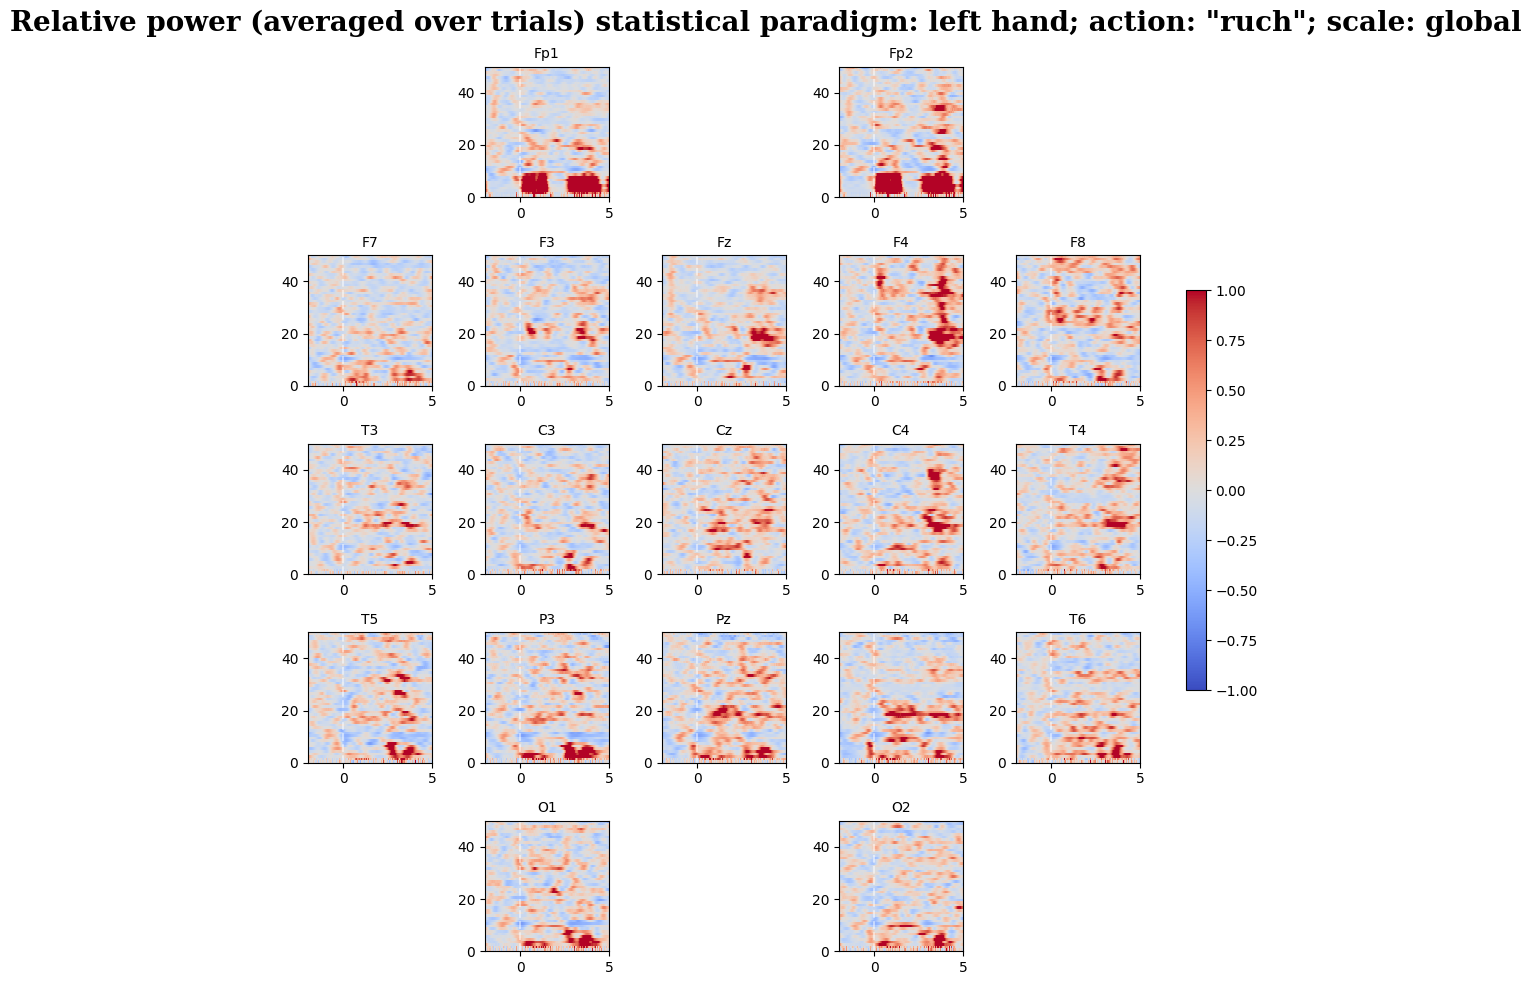

In [15]:
side = ['left', 0]
scale = 'global'
freq_limit = 50

Sxx_left_relative= relative_power(Sxx_left)
EEG_topology(Sxx_left_relative, t_left, f_left, title = f'Relative power (averaged over trials) statistical paradigm: {side[0]} hand; action: "{signal_type}"; scale: {str(scale)}', 
            f_limit = freq_limit, global_scale=True, vmin = -1, vmax = 1)

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_4652/2889181743.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Dopasowanie, żeby nie nachodziło na colorbar


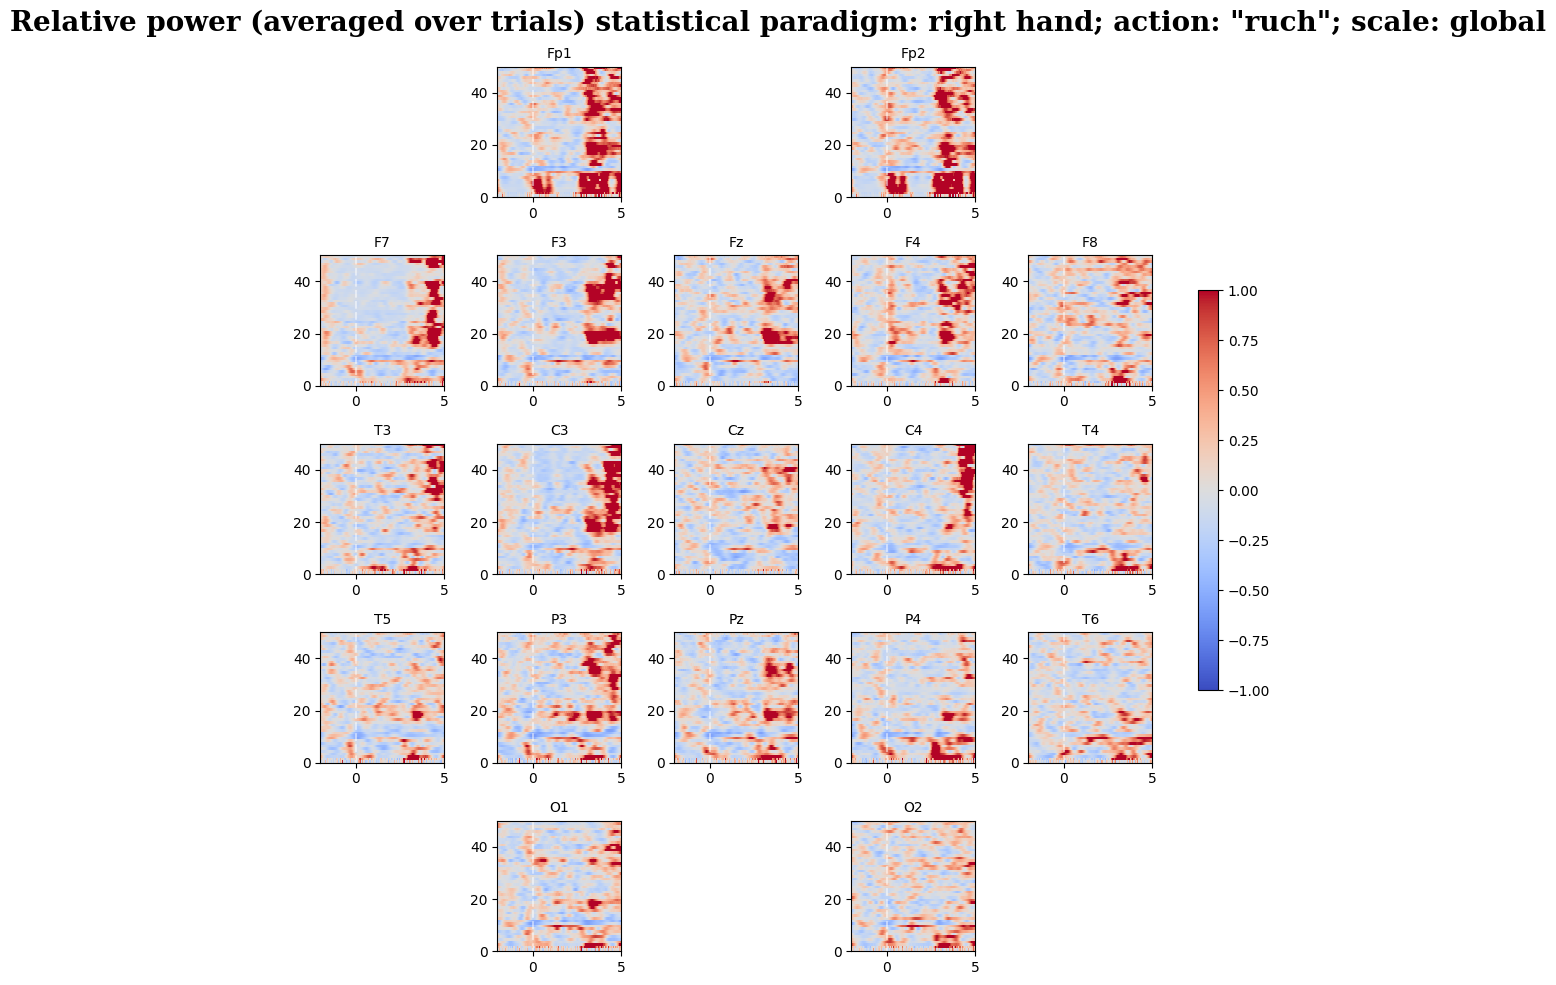

In [16]:
side = ['right', 1]
scale = 'global'
freq_limit = 50

Sxx_right_relative= relative_power(Sxx_right)
EEG_topology(Sxx_right_relative, t_right, f_right, title = f'Relative power (averaged over trials) statistical paradigm: {side[0]} hand; action: "{signal_type}"; scale: {str(scale)}', 
            f_limit = freq_limit, global_scale=True, vmin = -1, vmax = 1)

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_4652/2889181743.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Dopasowanie, żeby nie nachodziło na colorbar


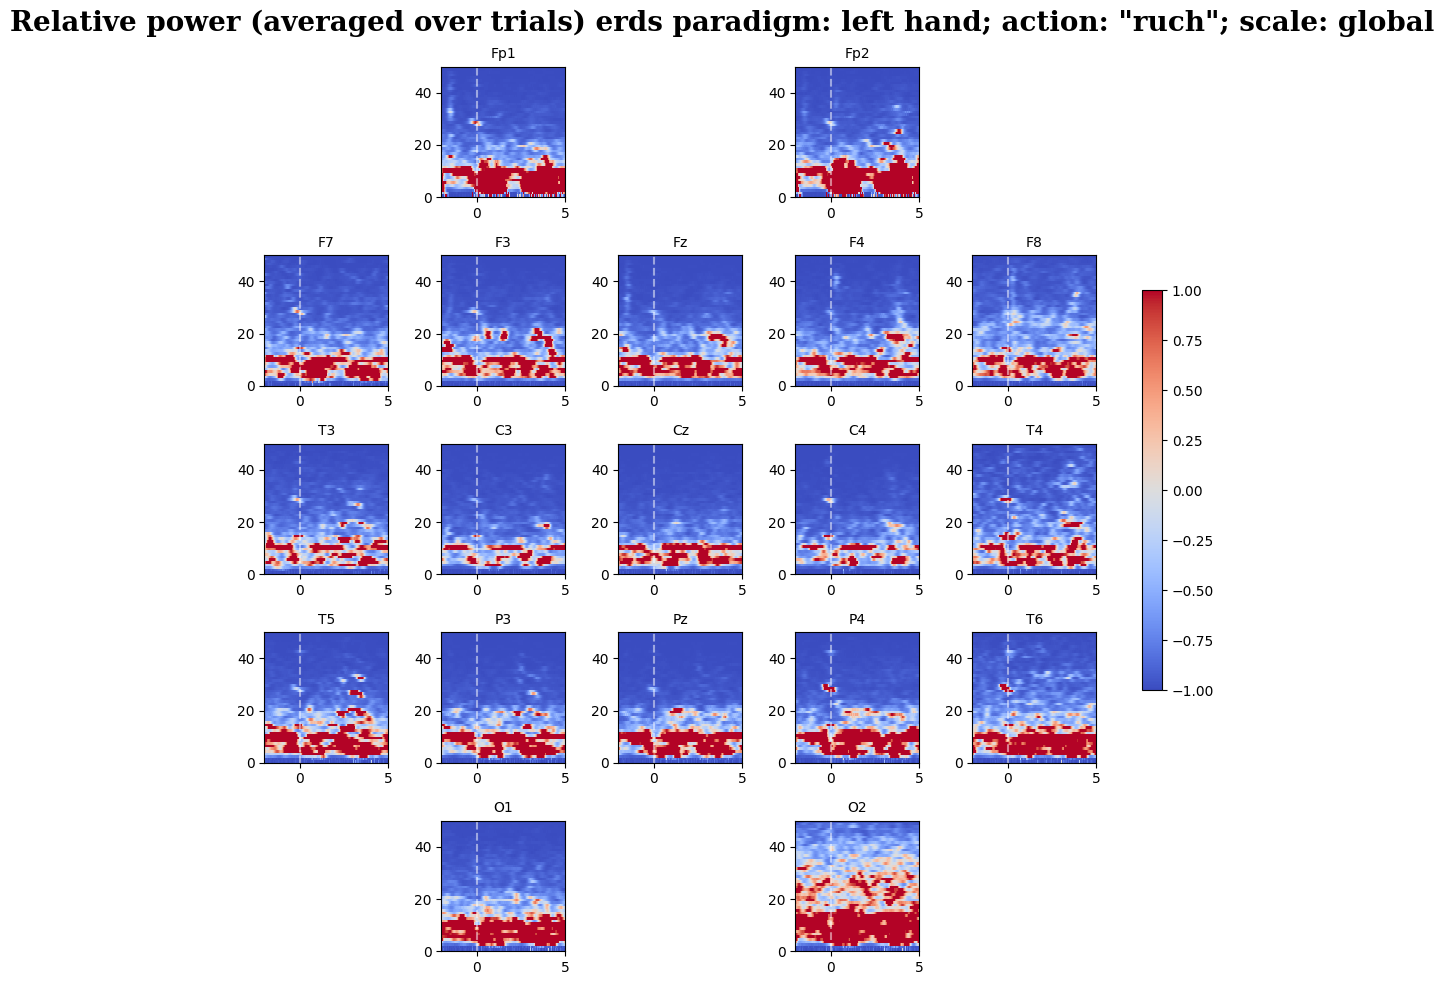

In [17]:
side = ['left', 0]
scale = 'global'
freq_limit = 50

Sxx_left_erds= erds(Sxx_left)
EEG_topology(Sxx_left_erds, t_left, f_left, title = f'Relative power (averaged over trials) erds paradigm: {side[0]} hand; action: "{signal_type}"; scale: {str(scale)}', 
            f_limit = freq_limit, global_scale=True, vmin = -1, vmax = 1)

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_4652/2889181743.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Dopasowanie, żeby nie nachodziło na colorbar


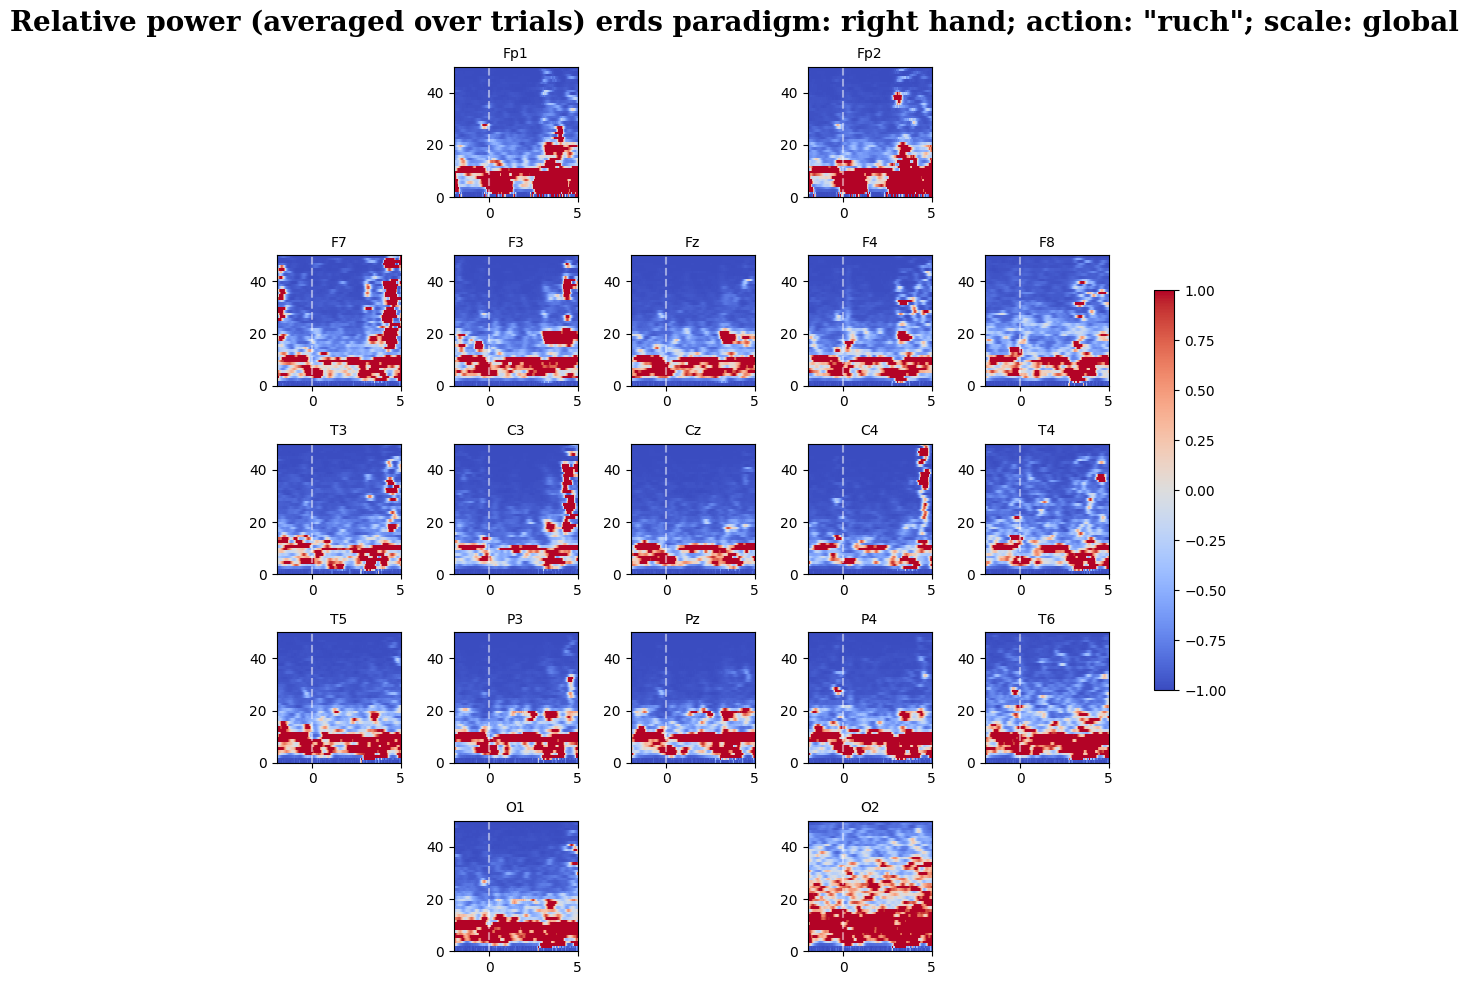

In [18]:
side = ['right', 1]
scale = 'global'
freq_limit = 50

Sxx_right_erds= erds(Sxx_right)
EEG_topology(Sxx_right_erds, t_right, f_right, title = f'Relative power (averaged over trials) erds paradigm: {side[0]} hand; action: "{signal_type}"; scale: {str(scale)}', 
            f_limit = freq_limit, global_scale=True, vmin = -1, vmax = 1)

Spacial filters - COMMON PATERNS SEPARATION (CPS)

We decided to NOT divide by trace!

In [19]:
from scipy.stats import Covariance

In [20]:
T = samples_count/Fs
t = np.arange(0,T, 1/Fs)

baseline_ind = np.where(t<2)[0]
move_ind = np.where(t>2)[0]

R_L = np.zeros((channels_count,channels_count))
R_P = np.zeros((channels_count,channels_count))
trial_count = 30

for trial in range(trial_count):
    L = EEG_mati['lewa'][trial, :, move_ind]
    tmp = np.cov(L, rowvar = False)
    R_L = R_L + tmp#/ np.trace(tmp)

    P = EEG_mati['prawa'][trial, :, move_ind]
    tmp = np.cov(P, rowvar = False)
    R_P = R_P + tmp#/ np.trace(tmp)

R_L = R_L/ trials_count
R_P = R_P/ trials_count

Lambda, W = sl.eigh(R_L, R_P)

Let's examin the W vector and then have a close-up on smaller values

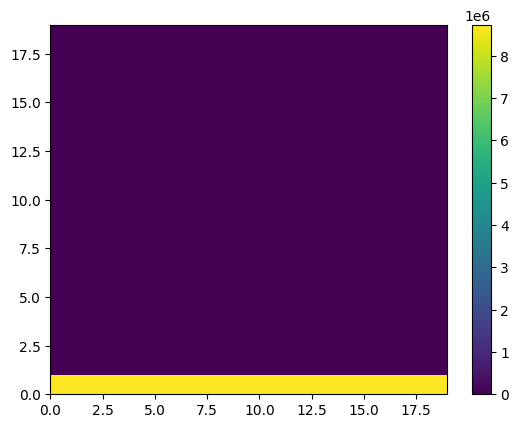

In [21]:
plt.pcolor(W.T)
plt.colorbar()

I wanted to also examine other vectors with 10e5 times lower amplitude 

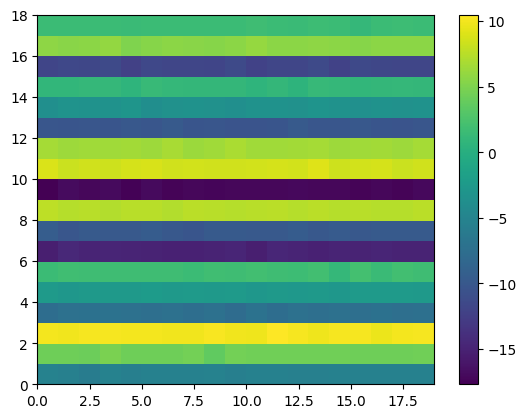

In [22]:
plt.pcolor(W[:, 1:].T)
plt.colorbar()

Then it's time to take a topology-oriented look and see how the chosen vector W (we have 19 vectors) looks on the head topology

In [23]:
def csp_topology(wektor, title, l=locs_uni, ch_names=channels_names, 
                 ax_title=channels_names, global_scale=False, vmin=None, vmax=None):

    plt.figure(figsize=(10, 10))
    plt.suptitle(title, fontsize=20, fontfamily='serif', fontweight='bold')

    # Automatyczne ustawienie zakresu kolorów
    if not global_scale:
        vmin, vmax = np.min(wektor), np.max(wektor)

    for ch in range(len(ch_names)):
        ax = plt.subplot(5, 5, l[ch])
        ax.set_title(ax_title[ch], fontsize=10)

        # Tworzenie macierzy 1x1 zawierającej tylko wartość wektora dla danego kanału
        color_matrix = np.array([[wektor[ch]]])

        # Wyświetlanie wartości jako kolor
        im = ax.imshow(color_matrix, cmap='coolwarm', vmin=vmin, vmax=vmax)

        # Wyświetlanie wartości liczbowej na środku
        ax.text(0, 0, f"{wektor[ch]:.2f}", ha='center', va='center', fontsize=12, 
                color='black', fontweight='bold')

        # Usunięcie osi dla czystego wyglądu
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)

    # Dodanie wspólnej skali kolorów jeśli global_scale=True
    if global_scale:
        cbar_ax = plt.gcf().add_axes([0.92, 0.3, 0.02, 0.4])  # Oś dla colorbar
        plt.colorbar(im, cax=cbar_ax)

    plt.tight_layout(rect=[0, 0, 0.9, 1])  
    plt.show()

W_topology calculation needs to be done only once. The values are now absolute. 

In [24]:
W_topology = np.abs(np.linalg.inv(W))

Vector 0 holds only 0 values, that's why I examined vector 1, but it wasn't attractive

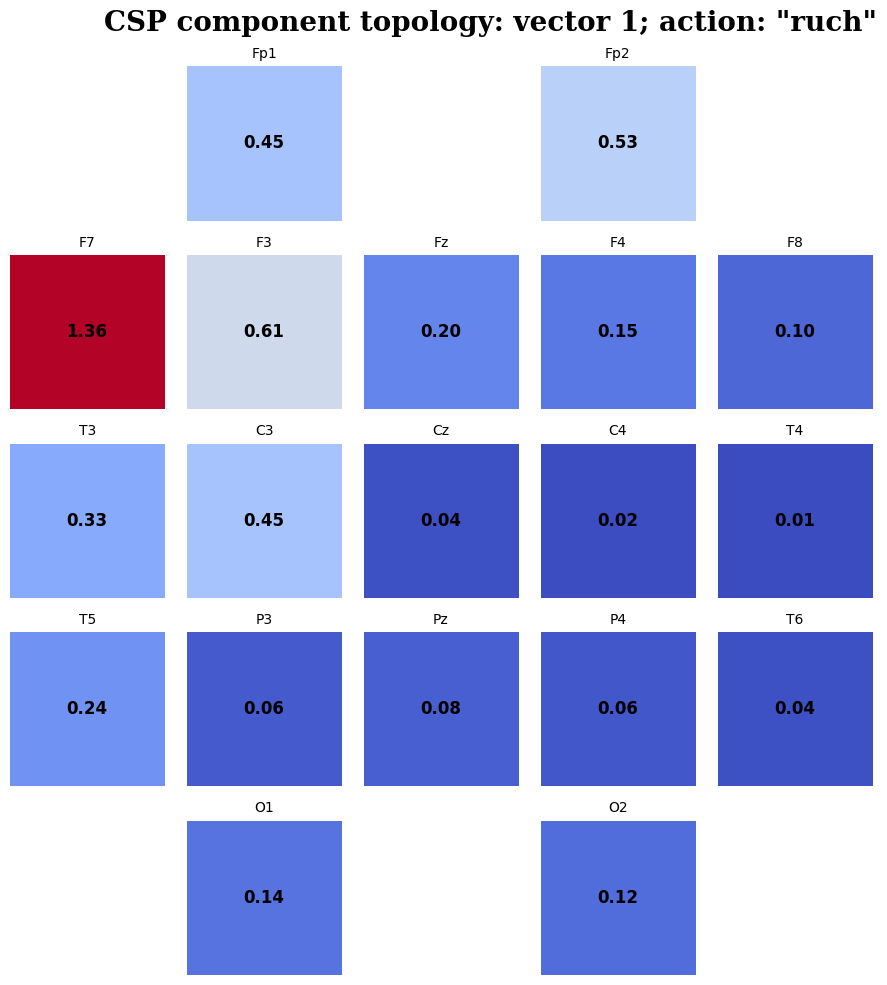

In [27]:
vector = '1'
scale = 'global'

W_01 = W_topology[1]
csp_topology(W_01, title = f'CSP component topology: vector {vector}; action: "{signal_type}"')

This is the topology for the first non-zero component (corresponding to eigenvalue 0.47). We can see it is focused on the frontal.

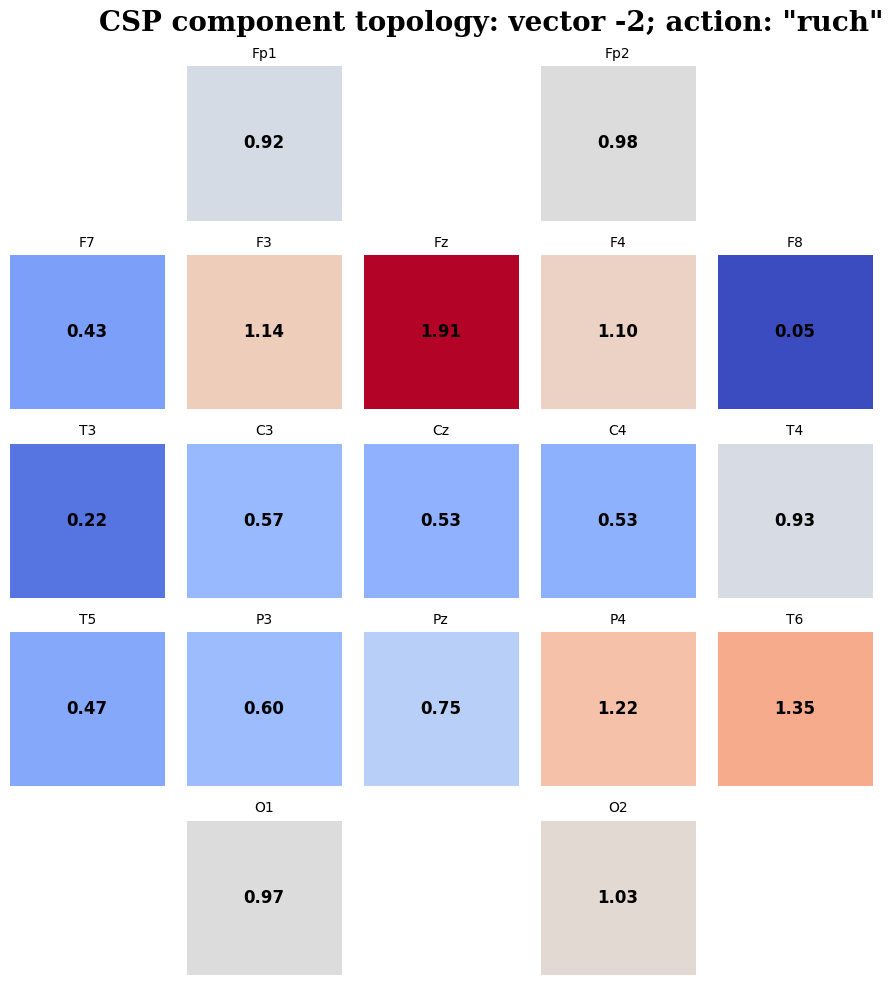

In [28]:
vector = '-2'
scale = 'global'

W_2 = np.abs(W_topology[-2])
csp_topology(W_2, title = f'CSP component topology: vector {vector}; action: "{signal_type}"')

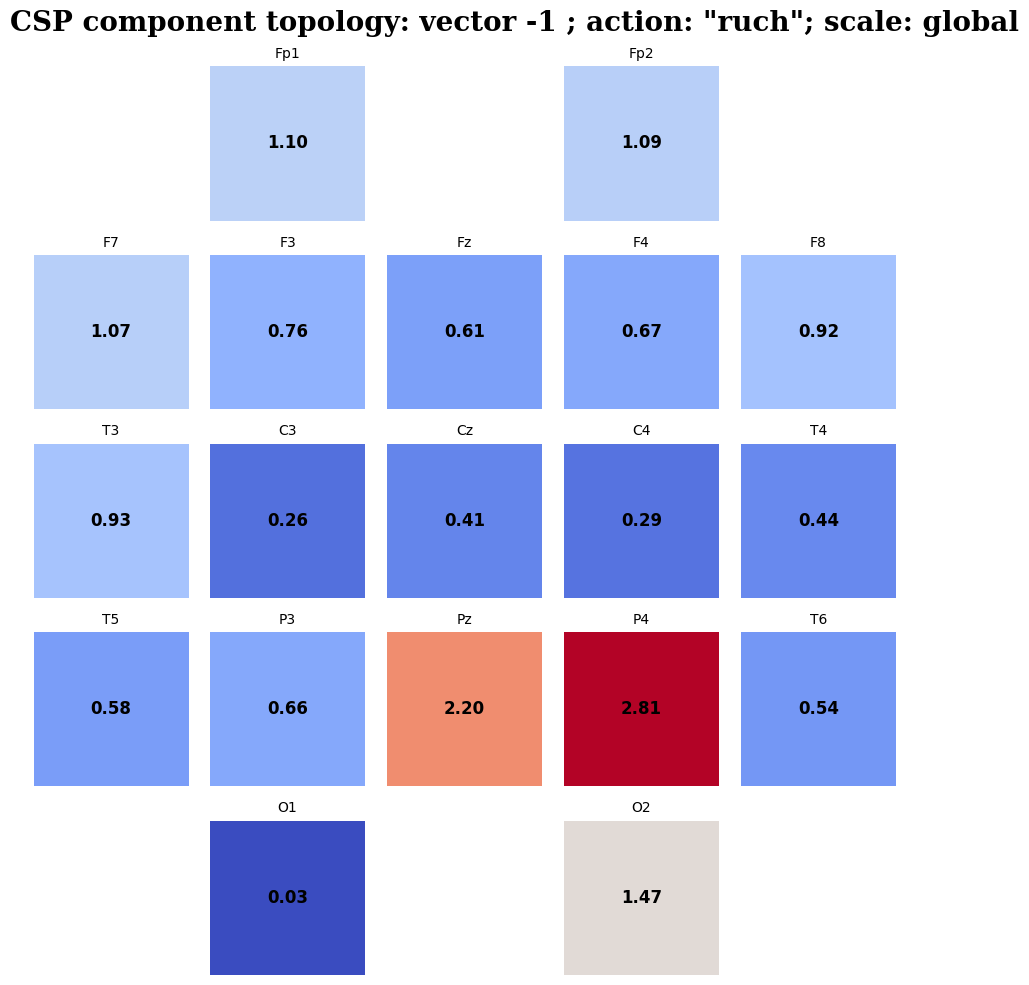

In [29]:
side = '-1'
scale = 'global'

W_1 = np.abs(W_topology[-1])
csp_topology(W_1, title = f'CSP component topology: vector {side} ; action: "{signal_type}"; scale: {str(scale)}')

This is topology for the last vector (biggest eigenvalue 1.3) -> let's assume that this is the correct localization for the CSP component responsible for movement

It is wanted to be resolved by eigh function: a @ v = b @ v @ w

In [30]:
Lambda #values examination

array([-4.92884135,  0.46510192,  0.61774587,  0.80791406,  0.81977059,
        0.83339523,  0.85287386,  0.89106171,  0.91935309,  0.93606198,
        0.9513063 ,  0.97568072,  0.99220599,  1.02379634,  1.06632903,
        1.08053267,  1.09067889,  1.17242364,  1.29753724])

Mind the "fancy indexing"

In [31]:
S_L = np.zeros((trials_count, channels_count, len(move_ind)))
S_P = np.zeros((trials_count, channels_count, len(move_ind)))

In [33]:
L = EEG_mati['lewa'][:, :, move_ind]
P = EEG_mati['prawa'][:, :, move_ind]

for trial in range(trials_count):
    S_L[trial, :, :] = W.T @ L[trial, :, :]
    S_P[trial, :, :] = W.T @ P[trial, :, :]

I checked and S_L and S_P hold non-zero values (after fixing a typo in the word "trial" in the loop)

- Let's add +2 to t_left_cps, because we don't involve beaseline
- We need to deteriorate the resolusion of time, because 1280 would be too much for classification (i change step in noverlap from 1 to 10)

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_4652/2889181743.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Dopasowanie, żeby nie nachodziło na colorbar


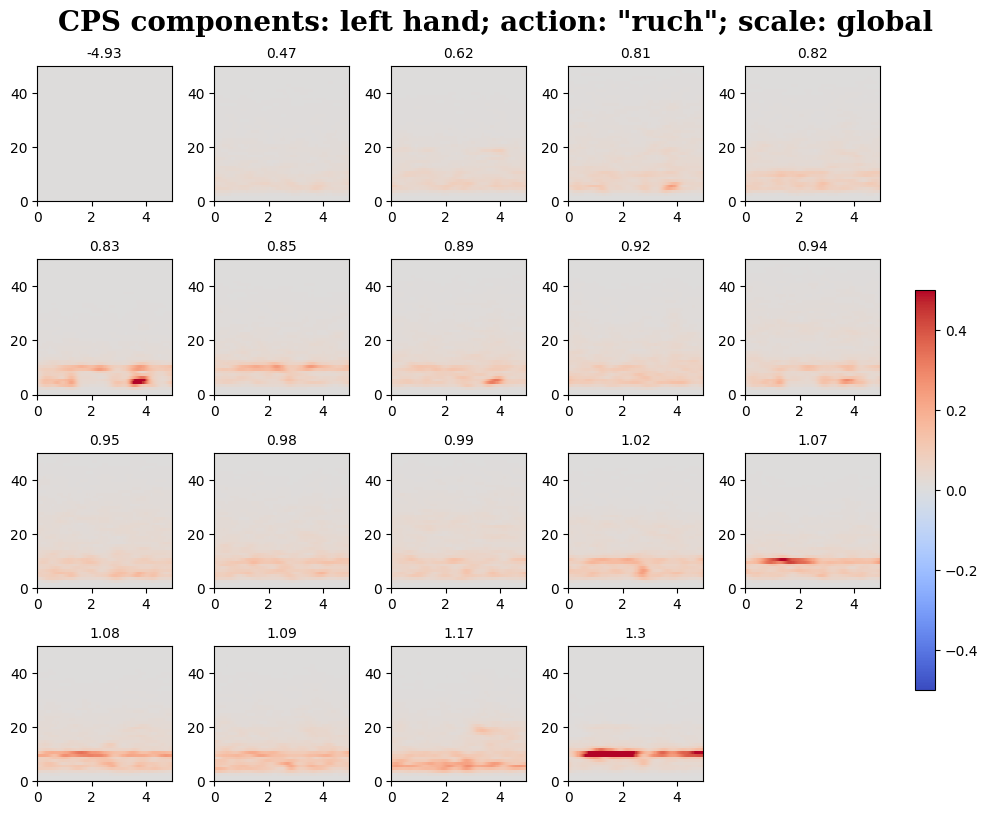

In [34]:
side = 'left'
scale = 'global'
freq_limit = 50

rounded_Lambda = list(map(lambda x: round(x, 2), Lambda))

Sxx_left_cps, t_left_cps, f_left_cps, Sxx_mean_left_cps = spectrogram(S_L, nlap = False)
t_left_cps = t_left_cps + 2
EEG_topology(Sxx_mean_left_cps, t_left_cps, f_left_cps, title = f'CPS components: {side} hand; action: "{signal_type}"; scale: {str(scale)}', 
            f_limit = freq_limit, global_scale=True, vmin = -0.5, vmax = 0.5, ax_title = rounded_Lambda, l = locs_standard)

/var/folders/0g/npb25fj57lgbq723mf4cfj580000gp/T/ipykernel_4652/2889181743.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Dopasowanie, żeby nie nachodziło na colorbar


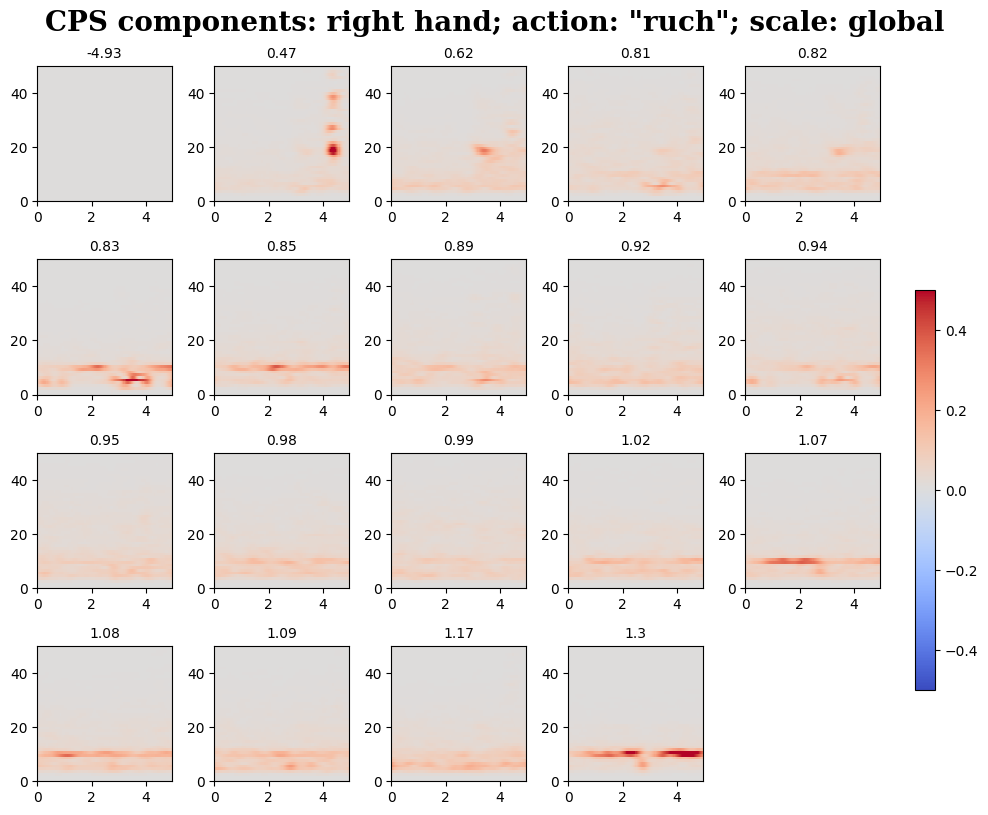

In [35]:
side = 'right'
scale = 'global'
freq_limit = 50

rounded_Lambda = list(map(lambda x: round(x, 2), Lambda))

Sxx_right_cps, t_right_cps, f_right_cps, Sxx_mean_right_cps = spectrogram(S_P, nlap = False)
t_right_cps = t_right_cps + 2

EEG_topology(Sxx_mean_right_cps, t_right_cps, f_right_cps, title = f'CPS components: {side} hand; action: "{signal_type}"; scale: {str(scale)}', 
            f_limit = freq_limit, global_scale=True, vmin = -0.5, vmax = 0.5, ax_title = rounded_Lambda, l = locs_standard)

Let's work on classification problem for the last component - corresponding to the eigenvalues 1.3

In [36]:
def data_acquisition_left(Sxx_left_cps, component_ind):
    # Pobranie widma dla lewej strony
    #ucinamy częstotliwości do 30 Hz

    #trail - freqs - time 
    spectrogram_left = Sxx_left_cps[:, component_ind, :30, :]
    trial_count = 30
    time_points = spectrogram_left.shape[-1]

    sig_left = np.zeros((30,30 * time_points + 1))

    for trial in range(trial_count):
        sig_left[trial][0:30 * time_points] += spectrogram_left[trial].reshape(-1)

    return pd.DataFrame(sig_left)


df_left = data_acquisition_left(Sxx_left_cps, -1)

In [37]:
def data_acquisition_right(Sxx_right_cps, component_ind):
    # Pobranie widma dla lewej strony
    #ucinamy częstotliwości do 30 Hz

    #trail - freqs - time 
    spectrogram_right = Sxx_right_cps[:, component_ind, :30, :]
    trial_count = 30
    time_points = spectrogram_right.shape[-1]

    sig_right = np.zeros((30,30 * time_points + 1))
    # Dodanie 30 zer na końcu ostatniego wymiaru (Z -> Z+30)
    for trial in range(trial_count):
        sig_right[trial][0:30 * time_points] += spectrogram_right[trial].reshape(-1)
        sig_right[trial][-1] += 1

    return pd.DataFrame(sig_right)


df_right = data_acquisition_right(Sxx_right_cps, -1)

We have 30 vectors (trails) per left and right and the last value 0 - left/ 1- right is label

In [38]:
df_left.rename(columns={df_left.columns[3840]: "label"}, inplace=True)
df_right.rename(columns={df_right.columns[3840]: "label"}, inplace=True)


In [39]:
dataset = pd.concat((df_left, df_right), axis = 0)

In [40]:
dataset

,0,1,2,3,4,5,6,7,8,9,...,3831,3832,3833,3834,3835,3836,3837,3838,3839,label
0,4.557908e-04,3.841928e-06,7.360659e-04,0.000319,2.464846e-03,3.042310e-03,9.088387e-03,9.266205e-05,8.156815e-03,1.465403e-03,...,0.001045,0.001458,0.002775,0.003778,0.004992,0.005592,7.039536e-03,0.007604,0.008441,0.0
1,1.652314e-04,4.042791e-04,1.739162e-04,0.001111,2.531183e-04,6.569149e-07,1.906292e-05,2.945310e-04,5.651454e-05,2.278986e-04,...,0.000361,0.000488,0.000918,0.001076,0.001095,0.000979,1.029249e-03,0.000600,0.000319,0.0
2,3.793117e-04,7.501036e-04,5.451318e-05,0.000025,1.048385e-04,1.362133e-03,4.657666e-03,1.199811e-05,9.800307e-05,1.565292e-03,...,0.000513,0.000190,0.000190,0.000721,0.001450,0.002718,3.330441e-03,0.004717,0.005403,0.0
3,5.282348e-05,1.485658e-06,2.468028e-03,0.000889,1.657988e-04,2.427664e-05,6.954060e-04,2.244404e-04,1.495370e-03,2.135958e-04,...,0.003262,0.004110,0.004956,0.006158,0.007289,0.007386,8.324981e-03,0.008600,0.008511,0.0
4,4.514819e-07,1.834324e-03,9.984818e-04,0.009487,1.583526e-03,3.801250e-03,8.425757e-03,4.613623e-03,3.411550e-06,2.129350e-03,...,0.002925,0.003380,0.003802,0.004158,0.004489,0.005525,5.437395e-03,0.005692,0.006035,0.0
5,1.140182e-03,8.814854e-05,3.664795e-04,0.000519,9.647241e-06,7.849356e-04,2.991789e-03,6.112478e-04,3.396270e-04,3.025492e-04,...,0.004112,0.004263,0.003867,0.004066,0.004414,0.005102,6.367051e-03,0.007796,0.008988,0.0
6,5.733173e-06,3.463291e-04,2.580864e-04,0.000198,1.048196e-03,1.135449e-04,1.182542e-02,4.969276e-03,1.246460e-03,4.848364e-03,...,0.000102,0.000050,0.000213,0.000426,0.000873,0.001261,1.332226e-03,0.001105,0.001081,0.0
7,7.621476e-07,1.028246e-03,2.372954e-04,0.000253,1.447502e-04,3.111812e-05,2.434634e-03,2.034673e-03,1.787250e-04,1.916762e-05,...,0.003948,0.003067,0.002499,0.002395,0.002004,0.002213,2.646053e-03,0.002822,0.003062,0.0
8,9.572704e-04,2.424046e-03,1.857533e-03,0.000629,8.035799e-04,6.869638e-04,8.012488e-04,3.703040e-03,2.527017e-04,6.996051e-05,...,0.003424,0.002706,0.001815,0.002685,0.002181,0.002045,2.038001e-03,0.003262,0.002898,0.0
9,2.299649e-04,6.376976e-04,8.578240e-05,0.000131,1.885172e-04,6.526176e-04,5.029398e-03,7.076241e-03,2.980966e-06,2.856376e-04,...,0.004642,0.003798,0.003154,0.002922,0.002223,0.001999,1.802691e-03,0.001874,0.002041,0.0


In [36]:
dataset.to_csv('datasets/dataset.csv', index=False)

I want to test various models for this classification task

Czy gdyby wstępnie sygnał przefiltrować tylko w paśmie miu to pozytywnie wpłynie? -> CSP

Potencjalne data leakage w macierzy W!